
1.   Metric To use :- roc auc score 
2.   Basic model :- KNN
3.   Hyperparameters to tune :- Neigbhours , oversampling ratio 



## Helper functions

In [6]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
# Plot learning curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, 
                                                          train_sizes=train_sizes,scoring="roc_auc")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Validation score")

    plt.legend(loc="best")
    return plt
# Plot validation curve
def plot_validation_curve(estimator, title, X, y, param_name, param_range, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    train_scores, test_scores = validation_curve(estimator, X, y, param_name, param_range, cv,scoring="roc_auc")
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    plt.plot(param_range, train_mean, color='r', marker='o', markersize=5, label='Training score')
    plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='r')
    plt.plot(param_range, test_mean, color='g', linestyle='--', marker='s', markersize=5, label='Validation score')
    plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color='g')
    plt.grid() 
    plt.xscale('log')
    plt.legend(loc='best') 
    plt.xlabel('Parameter') 
    plt.ylabel('Score') 
    plt.ylim(ylim)

In [9]:
def agg_groupby(df,primary_key,operations,agg_cols):
      return df.groupby(primary_key).agg(operations).reset_index().rename(columns=agg_cols)

def left_join(df1,df2,primary_key):
      return df1.merge(df2,how='left',on=primary_key)

def aggregation(df,primary_key,operation,cols):
    for c in cols:
        df=left_join(df,
                 agg_groupby(df,
                             [primary_key],
                             {c:operation},
                             {c:primary_key+"_"+operation+"_"+c}),
                 primary_key)
    return df

def remove_uniqueVal_cols(df):
    counts=df.nunique()
    to_del = [i for i,v in enumerate(counts) if v == 1]
    col_names_del=df.nunique().index[to_del]
    df.drop(col_names_del,axis=1,inplace=True)
    return df

# Lean Model 

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [10]:
train=pd.read_csv("../Training Data.csv")

In [11]:
train.head()

,Id,income,age,experience,married,house_ownership,car_ownership,profession,city,state,current_job_years,current_house_years,risk_flag
0,1,1303835,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1
4,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1


In [12]:
train=pd.get_dummies(data=train,columns=["house_ownership","married","car_ownership"],drop_first=True)
train.drop(["Id","profession","city","state"],axis=1,inplace=True)

In [13]:
train.head()

,income,age,experience,current_job_years,current_house_years,risk_flag,house_ownership_owned,house_ownership_rented,married_single,car_ownership_yes
0,1303835,23,3,3,13,0,0,1,1,0
1,7574516,40,10,9,13,0,0,1,1,0
2,3991815,66,4,4,10,0,0,1,0,0
3,6256451,41,2,2,12,1,0,1,1,1
4,5768871,47,11,3,14,1,0,1,1,0


In [14]:
X=train.drop("risk_flag",axis=1)
y=train["risk_flag"]
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val=train_test_split(X,y,test_size=0.2,shuffle=True,random_state=0)

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
knn=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=-1, n_neighbors=7, p=2,
                     weights='distance')

<module 'matplotlib.pyplot' from 'f:\\data science\\data\\univ_data\\univ\\lib\\site-packages\\matplotlib\\pyplot.py'>

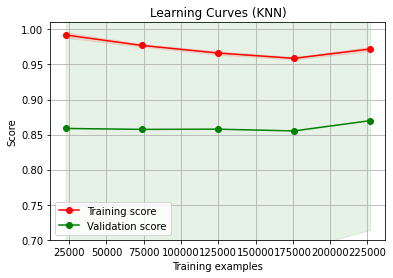

In [16]:
plot_learning_curve(knn,"Learning Curves (KNN)",X,y,ylim=(0.7, 1.01),cv=10)

 Indicates overfitting of model 

f:\data science\data\univ_data\univ\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass param_name=n_neighbors, param_range=[5, 7, 9, 11, 21], groups=None as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


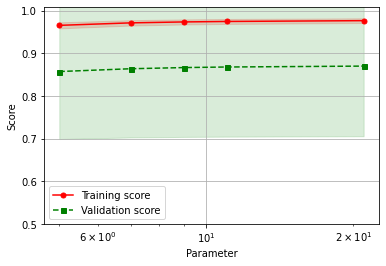

In [17]:
plot_validation_curve(knn,"Validation Curve (KNN)",X,y,param_name="n_neighbors",param_range=[5,7,9,11,21],ylim=(0.5, 1.01))

Constant across all the parameters , overfitting is also visible

# **EDA**

## Features 

1.   Id :- Unique identifier :- should not have any effect of risk flag 
2.   Income :- More the income better the chance of risk flag being 0 
3.   Age :- Hard to draw any relations. But younger age means finacially unstable that might lead to more risky loans
4.   experience :- More the experience better the chances of being financially well of thus less risky 
5.   married :- Married person usually is more finacially careful thus less risky
6.   house_ownership :- less risky loan if owns house 
7.   car_ownership :- maybe less risky but should not effect that much
8.   profession :- Better earning profession are less risker to give loans.
9.   city:- Should not effect unless some hidden feature
10.  state:- Should not effect unless some hidden feature
11.  current_job_years :- same as experience 
12.  current house_years :- more house years mean more financially stables but not necessarily - may or may not effect risk of loan



In [111]:
train=pd.read_csv("/content/drive/MyDrive/univ.ai/univ_data/Training Data.csv")

In [116]:
train.columns

Index(['Id', 'income', 'age', 'experience', 'married', 'house_ownership',
       'car_ownership', 'profession', 'city', 'state', 'current_job_years',
       'current_house_years', 'risk_flag'],
      dtype='object')

In [ ]:
plt.figure(figsize=(7.5,5))
sns.boxplot(data=train,x="income",y="risk_flag")

In [ ]:
plt.figure(figsize=(7.5,5))
sns.boxplot(data=train,x="age",y="risk_flag")

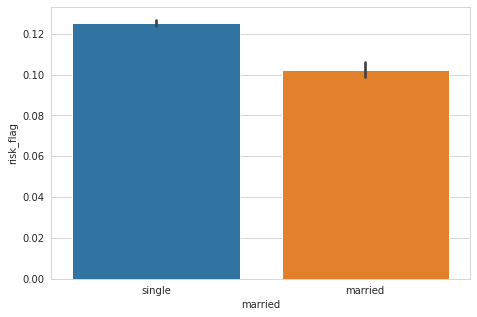

In [113]:
plt.figure(figsize=(7.5,5))
sns.barplot(data=train,x="married",y="risk_flag")

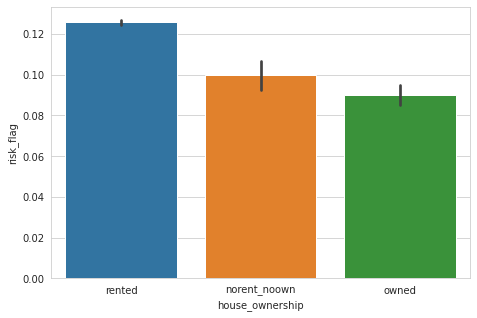

In [117]:
plt.figure(figsize=(7.5,5))
sns.barplot(data=train,x="house_ownership",y="risk_flag")

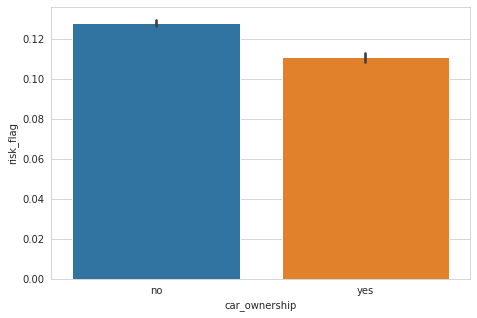

In [118]:
plt.figure(figsize=(7.5,5))
sns.barplot(data=train,x="car_ownership",y="risk_flag")

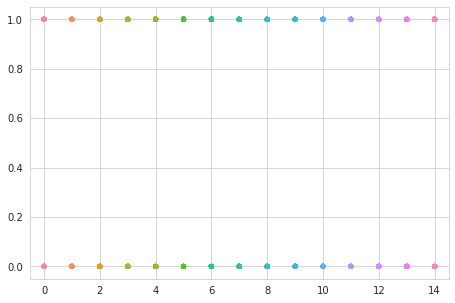

In [120]:
plt.figure(figsize=(7.5,5))
sns.swarmplot(data=train,x="current_job_years",y="risk_flag")

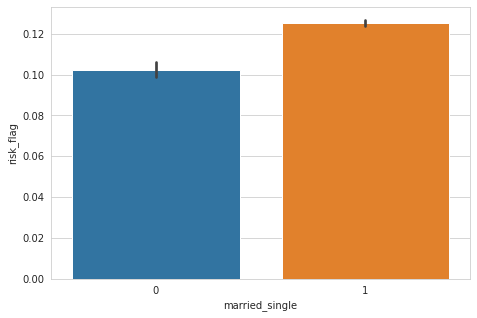

In [88]:
plt.figure(figsize=(7.5,5))
sns.boxplot(data=train,x="current_house_years",y="risk_flag")

# Feature Enginnering 

In [25]:
test=pd.read_csv("../Test Data.csv")
train=pd.read_csv("../Training Data.csv")
test.rename(columns={"id":"Id"},inplace=True)

In [26]:
train_no_target=train.drop("risk_flag",axis=1)
y=train["risk_flag"]

### MCA and PCA 

In [27]:
categorical_cols= ['car_ownership', 'profession', 'city','state','house_ownership','married','car_ownership']
numerical_cols =  ['income', 'age', 'experience', 'current_job_years','current_house_years']

In [28]:
from sklearn.decomposition import PCA
pca_matrix=pd.concat([train_no_target,test],axis=0)
pca= PCA(n_components=2,random_state=202020).fit(pca_matrix[numerical_cols])
train_no_target.loc[:,'PCA1']= pca.transform(train_no_target[numerical_cols])[:,0]
test.loc[:,'PCA1']= pca.transform(test[numerical_cols])[:,0]

train_no_target.loc[:,'PCA2']= pca.transform(train_no_target[numerical_cols])[:,1]
test.loc[:,'PCA2']= pca.transform(test[numerical_cols])[:,1]

In [29]:
loans=pd.concat([train_no_target,test],axis=0)

In [30]:
!pip install prince

You should consider upgrading via the 'F:\Data Science\Data\univ_data\univ\Scripts\python.exe -m pip install --upgrade pip' command.


In [31]:
import prince
mca = prince.MCA(n_components=2,random_state=42)
mca_features=mca.fit_transform(loans[categorical_cols])
loans.loc[:,'MCA1']=mca_features[0]
loans.loc[:,'MCA2']=mca_features[1]

MemoryError: Unable to allocate 121. MiB for an array with shape (453, 280000) and data type uint8

In [ ]:
loans.head()

### Income

In [ ]:
from scipy.stats import boxcox
# train['income_boxcox'] = boxcox(train['income'] + 1)[0]
# test['income_boxcox'] = boxcox(test['income'] + 1)[0]
loans['income_boxcox'] = boxcox(loans['income'] + 1)[0]

### States

In [ ]:
def correct_states(state):
  if (state=="Uttar_Pradesh[5]" or state=="Uttar Pradesh[5]" or state=="Uttar Pradesh"):
    return "Uttar_Pradesh"
  elif (state=="Andhra Pradesh"):
    return "Andhra_Pradesh"
  elif (state=="West Bengal"):
    return "West_Bengal"
  elif (state=="Jammu and Kashmir"):
    return "Jammu_and_Kashmir"
  elif (state=="Tamil Nadu"):
    return "Tamil_Nadu"
  elif (state=="Madhya Pradesh"):
    return "Madhya_Pradesh"
  elif (state=="Himachal Pradesh"):
    return "Himachal_Pradesh"
  else:
    return state

In [ ]:
# train["state"]=train["state"].apply(lambda x:correct_states(x))
# test["state"]=test["state"].apply(lambda x:correct_states(x))

loans["state"]=loans["state"].apply(lambda x:correct_states(x))

In [ ]:
agg_cols=["income","age","experience","current_house_years"]
oper=["mean","min","max","std"]
for op in oper:
  loans=aggregation(loans,"state",op,agg_cols)
  #train=aggregation(train,"state",op,agg_cols)
  #test=aggregation(test,"state",op,agg_cols)

In [17]:
# train=remove_uniqueVal_cols(train)
# test=remove_uniqueVal_cols(test)
loans=remove_uniqueVal_cols(loans)

### Profession 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]),
 <a list of 51 Text major ticklabel objects>)

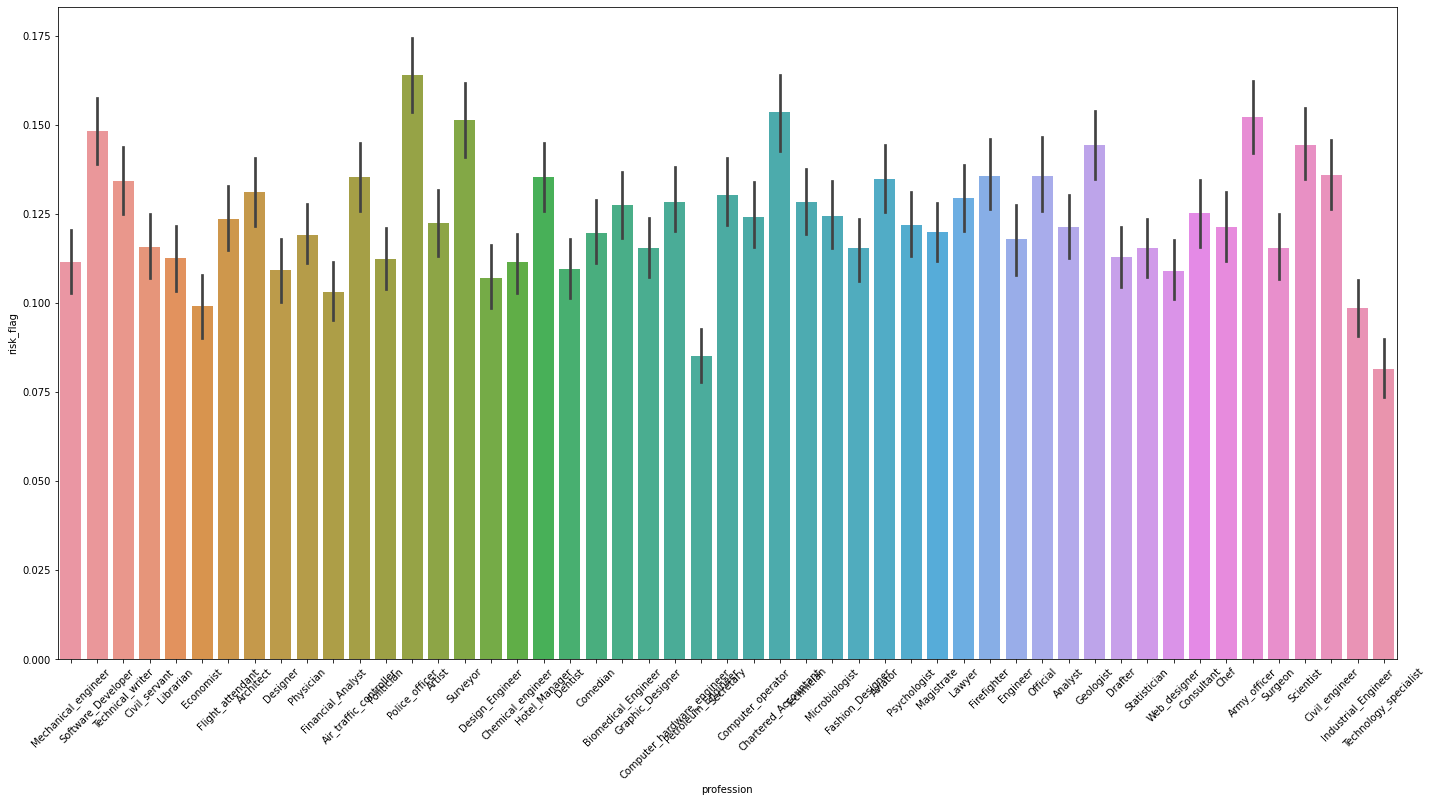

In [18]:
plt.figure(figsize=(24,12))
sns.barplot(data=train,x="profession",y="risk_flag")
plt.xticks(rotation=45)

In [19]:
profession_dict=(train[train["risk_flag"]==0].groupby("profession")["risk_flag"].count()/train[train["risk_flag"]==1].groupby("profession")["risk_flag"].count()).sort_values().to_dict()

In [20]:
loans["profession_score"]=loans["profession"].map(profession_dict)
loans["profession_score"]=loans.profession_score.fillna(value=loans.profession_score.mean())

In [21]:
train_after_fe = loans[:len(train)]
test  = loans[len(train):]
print(train_after_fe.shape,test.shape)

(252000, 29) (28000, 29)


In [22]:
train_with_target=train_after_fe.copy()
train_with_target["risk_flag"]=y

In [23]:
np.abs(train_with_target.corr()["risk_flag"]).sort_values(ascending=False)

risk_flag                         1.000000e+00
profession_score                  4.813619e-02
experience                        3.452261e-02
Id                                3.215350e-02
PCA2                              2.181207e-02
age                               2.180927e-02
current_job_years                 1.694158e-02
state_min_age                     1.638324e-02
MCA1                              1.613401e-02
state_mean_income                 1.268664e-02
state_std_experience              1.065126e-02
state_mean_current_house_years    9.336790e-03
state_std_age                     8.628858e-03
state_mean_age                    7.970306e-03
state_min_income                  6.723726e-03
state_std_income                  6.343137e-03
state_max_income                  5.290158e-03
income_boxcox                     4.726866e-03
current_house_years               4.375163e-03
state_mean_experience             3.883355e-03
PCA1                              3.091168e-03
income       

# Preprocessing 

In [24]:
train_after_fe=pd.get_dummies(data=train_after_fe,columns=["house_ownership","married","car_ownership"],drop_first=True)
train_after_fe.drop(["profession","city","state"],axis=1,inplace=True)

test=pd.get_dummies(data=test,columns=["house_ownership","married","car_ownership"],drop_first=True)
test.drop(["profession","city","state"],axis=1,inplace=True)

In [25]:
train_id=train_after_fe["Id"]
test_id=test["Id"]
train_after_fe.drop("Id",axis=1,inplace=True)
test.drop("Id",axis=1,inplace=True)

In [26]:
display(train_after_fe.head())
display(test.head())

,income,age,experience,current_job_years,current_house_years,PCA1,PCA2,MCA1,MCA2,income_boxcox,state_mean_income,state_mean_age,state_mean_experience,state_mean_current_house_years,state_min_income,state_min_age,state_max_income,state_std_income,state_std_age,state_std_experience,state_std_current_house_years,profession_score,house_ownership_owned,house_ownership_rented,married_single,car_ownership_yes
0,1303835,23,3,3,13,-3.696526e+06,-26.983843,0.481663,0.288990,30789.443795,4.891034e+06,49.652254,10.551495,12.012499,13629,21,9994932,2.890223e+06,16.976140,5.913636,1.451546,7.963918,0,1,1,0
1,7574516,40,10,9,13,2.574155e+06,-9.952688,0.203566,0.191450,107313.465390,5.017456e+06,50.136905,10.012926,11.935968,10318,21,9987388,2.908268e+06,17.043653,5.887652,1.409368,5.737333,0,1,1,0
2,3991815,66,4,4,10,-1.008546e+06,16.033857,0.053889,-0.425584,68115.754320,5.153478e+06,50.800439,8.561373,12.071014,16212,21,9987955,2.772674e+06,16.652109,5.713648,1.473761,6.453372,0,1,0,0
3,6256451,41,2,2,12,1.256090e+06,-8.960311,0.327451,-0.936579,93699.322542,4.931571e+06,49.287296,11.217366,12.014763,13696,21,9991569,2.945648e+06,17.294016,6.265665,1.344554,5.737333,0,1,1,1
4,5768871,47,11,3,14,7.685097e+05,-2.966084,0.404185,0.624773,88456.809009,5.039721e+06,50.070736,10.391432,11.987109,11511,21,9994061,2.872677e+06,16.621882,5.945461,1.423089,7.636008,0,1,1,0


,income,age,experience,current_job_years,current_house_years,PCA1,PCA2,MCA1,MCA2,income_boxcox,state_mean_income,state_mean_age,state_mean_experience,state_mean_current_house_years,state_min_income,state_min_age,state_max_income,state_std_income,state_std_age,state_std_experience,state_std_current_house_years,profession_score,house_ownership_owned,house_ownership_rented,married_single,car_ownership_yes
252000,7393090,59,19,4,13,2.392729e+06,9.042886,-0.137017,-0.326405,105483.049885,5.119232e+06,50.090696,9.920962,11.973309,10310,21,9989145,2.892572e+06,17.008579,5.996778,1.407246,5.931751,0,1,1,0
252001,1215004,25,5,5,10,-3.785357e+06,-24.978106,0.018459,0.075065,29285.644937,5.017456e+06,50.136905,10.012926,11.935968,10318,21,9987388,2.908268e+06,17.043653,5.887652,1.409368,6.364379,0,1,1,0
252002,8901342,50,12,9,14,3.900981e+06,0.051408,-0.007750,0.134789,120336.990962,5.017456e+06,50.136905,10.012926,11.935968,10318,21,9987388,2.908268e+06,17.043653,5.887652,1.409368,6.721154,0,1,1,0
252003,1944421,49,9,3,12,-3.055940e+06,-0.979750,-0.726737,0.176913,40885.809138,5.017456e+06,50.136905,10.012926,11.935968,10318,21,9987388,2.908268e+06,17.043653,5.887652,1.409368,7.232804,0,1,0,1
252004,13429,25,18,13,11,-4.986932e+06,-24.981667,-0.876851,-0.251879,1196.201963,5.119232e+06,50.090696,9.920962,11.973309,10310,21,9989145,2.892572e+06,17.008579,5.996778,1.407246,7.360890,0,1,1,1


In [27]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_after_fe)
test_scaled = scaler.transform(test)

# Polynomial features

In [28]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2).fit(train_after_fe)

In [29]:
train_poly=poly.transform(train_scaled)
test_poly=poly.transform(test_scaled)

In [30]:
print(test_poly.shape,train_poly.shape,y.shape)

(28000, 378) (252000, 378) (252000,)


# Feature Selection 

In [31]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.neighbors import KNeighborsClassifier

## Get score using original model
knn =KNeighborsClassifier(n_neighbors=7)
knn.fit(train_poly,y)
scores = cross_val_score(knn,train_poly,y,cv=5,scoring="roc_auc")
print('ROC AUC (original): %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))
highest_score = np.mean(scores)

## Get score using models with feature selection
for i in range(1, train_poly.shape[1]+1, 5):
    # Select i features
    select = SelectKBest(score_func=chi2, k=i)
    select.fit(train_poly,y)
    X_train_poly_selected = select.transform(train_poly)

    # Model with i features selected
    knn.fit(X_train_poly_selected, y)
    scores = cross_val_score(knn, X_train_poly_selected, y, cv=5,scoring="roc_auc")
    print('ROC AUC (number of features = %i): %.3f +/- %.3f' % (i, 
                                                                     np.mean(scores), 
                                                                     np.std(scores)))
    
    # Save results if best score
    if np.mean(scores) > highest_score:
        highest_score = np.mean(scores)
        std = np.std(scores)
        k_features_highest_score = i
    elif np.mean(scores) == highest_score:
        if np.std(scores) < std:
            highest_score = np.mean(scores)
            std = np.std(scores)
            k_features_highest_score = i
        
# Print the number of features
print('Number of features when highest score: %i' % k_features_highest_score)

ROC AUC (original): 0.863 +/- 0.164
ROC AUC (number of features = 1): 0.515 +/- 0.029
ROC AUC (number of features = 6): 0.527 +/- 0.024
ROC AUC (number of features = 11): 0.548 +/- 0.030
ROC AUC (number of features = 16): 0.644 +/- 0.071
ROC AUC (number of features = 21): 0.645 +/- 0.064
ROC AUC (number of features = 26): 0.861 +/- 0.161


KeyboardInterrupt: ignored

# Trying out more models

In [ ]:
def train_model(model,x_train,y_train,x_val,y_val,print_feature_imp=False,print_cm=True,col_names):
  from sklearn.metrics import roc_auc_score
  import seaborn as sns
  import matplotlib.pyplot as plt
  import pandas as pd
  import numpy as np

  print("Training on", model)
  model.fit(x_train,y_train,verbose=True)
  print("Predicting values on validation dataset")
  pred=model.predict(x_val)
  if print_feature_imp==True:
    fi=pd.DataFrame({'Features':col_names,'Scores':model.feature_importances})
    fi = fi.sort_values(by='Feature importance',ascending=False)
    plt.figure(figsize=(7,5))
    plt.title("Feature Importance",fontsize=14)
    s=sns.barplot(data=fi,x="Features",y="Scores")
    s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.show()
  if print_cm=True:
    cm=pd.crosstab(y_val,pred,
                   rownames=["Actual"],
                   colnames=["Predicted"])
    
    fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
    sns.heatmap(cm,
                xticklabels=["Not risky","Risky"],
                yticklabels=["Not risky","Risky"],
                linewidths=.2,linecolor="Darkblue", cmap="Blues",
                annot=True,ax=ax1
                )
    plt.title("Confusion Matrix",fontsize=14)
    plt.show()

    print("ROC AUC Score on validation dataset: ",roc_auc_score(y_val,pred))

  return model

### KNN hyperparameter tuning 

### RandomForest 

### Adaboost 

### Catboost 

### XGBboost

### LightGBM